In [27]:
import h5py
import argparse
import os, sys
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors

In [28]:
from matplotlib import ticker
import matplotlib as mpl
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

In [29]:
compare_cnn = False
save_folder_name = "/mnt/home/micall12/LowEnergyNeuralNetwork/output_plots/final_data/"
keys = ["nutau", "nue", "numu", "mu", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"]
MC = keys[:4]
data = keys[4:]
weights_files = {}
weights_files["nutau"] = 334 #95
weights_files["nue"] = 602 #92
weights_files["numu"] = 1518 #99
weights_files["mu"] =17992

truth = {}
predict = {}
weights = {}
info = {}
for i,key in enumerate(keys):
    input_file = "/mnt/home/micall12/LowEnergyNeuralNetwork/output_plots/final_data/prediction_values_%s.hdf5"%key
    f = h5py.File(input_file, 'r')
    truth[key] = f["Y_test_use"][:]
    predict[key] = f["Y_predicted"][:]
    raw_weights = f["weights_test"][:]
    print(key,truth[key].shape[0])
    if key in MC:
        weights[key] = raw_weights[:,8]/weights_files[key]
        print(sum(weights[key])*1000)
    info[key] = f["additional_info"][:]
    
    f.close()
    del f

nutau 2010101
0.0977016053899716
nue 2003613
0.502474875119376
numu 4619026
1.5479897865533354
mu 148089
0.9899870257654303
2012 87051
2013 90124
2014 95792
2015 95622
2016 94376
2017 106119
2018 95561
2019 81196
2020 94603
2021 62441


In [30]:
#CUT values
cut1 = {}
cut1['r'] = 200 #165
cut1['zmin'] = -495
cut1['zmax'] = -225
cut1['coszen'] = 0.3
cut1['emin'] = 5
cut1['emax'] = 100
cut1['mu'] = 0.8 #0.2
cut1['nDOM'] = 7

In [31]:
#Truth
true = {}
reco = {}
mask = {}
more_info = {}
for i,key in enumerate(keys):
    true[key] = {}
    reco[key] = {}
    mask[key] = {}
    more_info[key] = {}
    
    true[key]['energy'] = np.array(truth[key][:,0])
    true[key]['em_equiv_energy'] = np.array(truth[key][:,14])
    true[key]['total_daughter_energy'] = np.array(truth[key][:,13])
    true[key]['x'] = np.array(truth[key][:,4])
    true[key]['y'] = np.array(truth[key][:,5])
    true[key]['z'] = np.array(truth[key][:,6])
    x1_origin = np.ones((len(true[key]['x'])))*46.290000915527344
    y1_origin = np.ones((len(true[key]['y'])))*-34.880001068115234
    true[key]['r'] = np.sqrt( (true[key]['x'] - x1_origin)**2 + (true[key]['y'] - y1_origin)**2 )
    true[key]['isCC'] = np.array(truth[key][:,11],dtype=bool)
    true[key]['isTrack'] = np.array(truth[key][:,8]) == 1
    true[key]['isCascade'] = np.array(truth[key][:,8]) == 0
    true[key]['PID'] = truth[key][:,9]
    true[key]['zenith'] = np.array(truth[key][:,12])
    true[key]['coszenith'] = np.cos(np.array(truth[key][:,12]))
    #ending calculation
    true[key]['azimuth'] = truth[key][:,2]
    true[key]['track_length'] = truth[key][:,7]
    n_x = np.sin(true[key]['zenith'])*np.cos(true[key]['azimuth'])
    n_y = np.sin(true[key]['zenith'])*np.sin(true[key]['azimuth'])
    n_z = np.cos(true[key]['zenith'])
    true[key]['x_end'] = true[key]['x'] + true[key]['track_length']*n_x
    true[key]['y_end'] = true[key]['y'] + true[key]['track_length']*n_y
    true[key]['z_end'] = true[key]['z'] + true[key]['track_length']*n_z
    true[key]['r_end'] = np.sqrt( (true[key]['x_end'] - x1_origin)**2 + (true[key]['y_end'] - y1_origin)**2 )
    try:
        true[key]['daughter_energy'] =  np.array(truth[key][:,15])
    except:
        true[key]['daughter_energy'] = None
        
    #Reconstructed values (CNN)
    reco[key] = {}
    reco[key]['energy'] = np.array(predict[key][:,0])
    reco[key]['prob_track'] = np.array(predict[key][:,1])
    reco[key]['zenith'] = np.array(predict[key][:,2])
    reco[key]['coszenith'] = np.cos(reco[key]['zenith'])
    reco[key]['x'] = np.array(predict[key][:,3])
    reco[key]['y'] = np.array(predict[key][:,4])
    reco[key]['z'] = np.array(predict[key][:,5])
    reco[key]['r'] = np.sqrt( (reco[key]['x'] - x1_origin)**2 + (reco[key]['y'] - y1_origin)**2 )
    reco[key]['prob_mu'] = np.array(predict[key][:,10]) #np.array(predict[key][:,6])
    reco[key]['CNN_mu'] = np.array(predict[key][:,9])
    reco[key]['nDOMs'] = np.array(predict[key][:,7])
    
        
    #RECO masks
    mask[key] = {}
    mask[key]['Energy'] = np.logical_and(reco[key]['energy'] > cut1['emin'], reco[key]['energy'] < cut1['emax'])
    mask[key]['Zenith'] = reco[key]['coszenith'] <= cut1['coszen']
    mask[key]['R'] = reco[key]['r'] < cut1['r']
    mask[key]['Z'] = np.logical_and(reco[key]['z'] > cut1['zmin'], reco[key]['z'] < cut1['zmax'])
    mask[key]['Vertex'] = np.logical_and(mask[key]['R'], mask[key]['Z'])
    mask[key]['ProbMu'] = reco[key]['prob_mu'] >= cut1['mu'] #<= cut1['mu']
    mask[key]['Reco'] = np.logical_and(mask[key]['ProbMu'], np.logical_and(mask[key]['Zenith'], np.logical_and(mask[key]['Energy'], mask[key]['Vertex'])))
    mask[key]['DOM'] = reco[key]['nDOMs'] >= cut1['nDOM']
    mask[key]['RecoNoEn'] = np.logical_and(mask[key]['ProbMu'], np.logical_and(mask[key]['Zenith'], mask[key]['Vertex']))
    mask[key]['RecoNoZenith'] = np.logical_and(mask[key]['ProbMu'], np.logical_and(mask[key]['Energy'], mask[key]['Vertex']))
    mask[key]['RecoNoZ'] = np.logical_and(mask[key]['ProbMu'], np.logical_and(mask[key]['Zenith'], np.logical_and(mask[key]['Energy'], mask[key]['R'])))
    mask[key]['RecoNoR'] = np.logical_and(mask[key]['ProbMu'], np.logical_and(mask[key]['Zenith'], np.logical_and(mask[key]['Energy'], mask[key]['Z'])))
    mask[key]['RecoNoMu'] = np.logical_and(mask[key]['Zenith'], np.logical_and(mask[key]['Energy'], mask[key]['Vertex']))
    mask[key]['RecoNoMuNoR'] = np.logical_and(mask[key]['Zenith'], np.logical_and(mask[key]['Energy'], mask[key]['Z']))
    mask[key]['All'] = true[key]['energy'] > 0
    true[key]['All'] = true[key]['energy'] > 0
    
    #PID identification
    muon_mask_test1 = (true[key]['PID']) == 13
    true[key]['isMuon'] = np.array(muon_mask_test1,dtype=bool)
    numu_mask_test1 = (true[key]['PID']) == 14
    true[key]['isNuMu'] = np.array(numu_mask_test1,dtype=bool)
    nue_mask_test1 = (true[key]['PID']) == 12
    true[key]['isNuE'] = np.array(nue_mask_test1,dtype=bool)
    nutau_mask_test1 = (true[key]['PID']) == 16
    true[key]['isNuTau'] = np.array(nutau_mask_test1,dtype=bool)
    nu_mask1 = np.logical_or(np.logical_or(numu_mask_test1, nue_mask_test1), nutau_mask_test1)
    true[key]['isNu'] = np.array(nu_mask1,dtype=bool)
    
    more_info[key]['prob_nu'] = info[key][:,1]
    more_info[key]['coin_muon'] = info[key][:,0]
    more_info[key]['true_ndoms'] = info[key][:,2]
    more_info[key]['fit_success'] = info[key][:,3]
    more_info[key]['noise_class'] = info[key][:,4]
    more_info[key]['nhit_doms'] = info[key][:,5]
    more_info[key]['n_top15'] = info[key][:,6]
    more_info[key]['n_outer'] = info[key][:,7]
    more_info[key]['prob_nu2'] = info[key][:,8]
    more_info[key]['total_hits'] = info[key][:,9]
    more_info[key]['z_min'] = info[key][:,-1]
    more_info[key]['time_window'] = info[key][:,-2]
    
    mask[key]['Hits8'] = more_info[key]['total_hits'] >= 8
    mask[key]['oscNext_Nu'] = more_info[key]['prob_nu'] > 0.8 #CHANGED FROM 0.4
    mask[key]['Noise'] = more_info[key]['noise_class'] > 0 #0.95
    mask[key]['nhit'] = more_info[key]['nhit_doms'] > 2.5
    mask[key]['ntop']= more_info[key]['n_top15'] < 0.5
    mask[key]['nouter'] = more_info[key]['n_outer'] < 7.5
    mask[key]['CoinHits'] = np.logical_and(np.logical_and(mask[key]['nhit'], mask[key]['ntop']), mask[key]['nouter'])
    mask[key]['MC'] = np.logical_and(mask[key]['CoinHits'],mask[key]['DOM'])
    
    mask[key]['Analysis'] = np.logical_and(mask[key]['MC'], mask[key]['Reco'])

In [32]:
mask_analysis = {}
mask_probnu = {}
times = {}
prob_nu = {}
isNu = {}
cnn_mu = {}

for i,key in enumerate(keys):
    if i >= len(MC):
        write_to = "data"
    else:
        write_to = "MC"
        print(key,sum(weights[key][mask[key]["Analysis"]]*1000), "mHz")
    if i == 0 or i== len(MC):
        mask_analysis[write_to] = mask[key]["Analysis"]
        mask_probnu[write_to] = np.logical_and(mask[key]["RecoNoMu"],mask[key]['MC'])
        times[write_to] = more_info[key]["time_window"]
        prob_nu[write_to] = reco[key]["prob_mu"]
        isNu[write_to] = true[key]["isNu"]
        cnn_mu[write_to] = reco[key]["CNN_mu"]
        if i < len(MC):
            weights[write_to] = weights[key]
    else:
        mask_analysis[write_to] = np.concatenate((mask_analysis[write_to],mask[key]["Analysis"]))
        mask_probnu[write_to] = np.concatenate((mask_probnu[write_to],np.logical_and(mask[key]["RecoNoMu"],mask[key]['MC'])))
        times[write_to] =  np.concatenate((times[write_to],more_info[key]["time_window"]))
        prob_nu[write_to] = np.concatenate((prob_nu[write_to], reco[key]["prob_mu"]))
        isNu[write_to] = np.concatenate((isNu[write_to], true[key]["isNu"]))
        cnn_mu[write_to] = np.concatenate((cnn_mu[write_to],reco[key]["CNN_mu"]))
        if i < len(MC):
            weights[write_to] = np.concatenate((weights[write_to],weights[key]))

nutau 0.04878796288665794 mHz
nue 0.18570854510013918 mHz
numu 0.5137696359446046 mHz
mu 0.004759760577024646 mHz


/mnt/home/micall12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


Text(0, 0.5, 'Rate (mHz)')

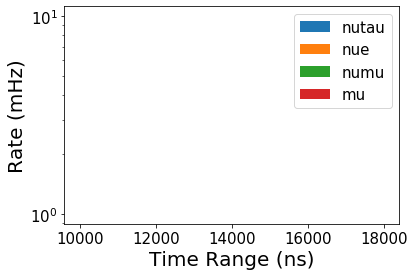

In [18]:
amin = 10000
amax = 18000
bins=20
list_times = []
list_weights = []
list_masks = []
for key in MC:
    mask_here = mask[key]["Analysis"]
    list_times.append(more_info[key]["time_window"][mask_here])
    list_weights.append(weights[key][mask_here]*1000)
plt.hist(list_times,weights=list_weights,stacked=True,label=MC,range=[amin,amax],bins=bins)
plt.legend(fontsize=15)
plt.xlabel("Time Range (ns)",fontsize=20)
plt.yscale('log')
plt.ylabel("Rate (mHz)",fontsize=20)

In [19]:
times["data"][:10]

array([11692., 11387., 10235., 10038., 10706., 10908., 13024., 10373.,
       10287., 10540.])

In [33]:
np.nansum(more_info['2012']['z_min'])

0.0

In [38]:
more_info['numu']

{'prob_nu': array([nan, nan, nan, ..., nan, nan, nan]),
 'coin_muon': array([1., 1., 1., ..., 1., 1., 1.]),
 'true_ndoms': array([ 6.,  8.,  8., ..., 21., 78., 83.]),
 'fit_success': array([0., 0., 0., ..., 0., 0., 0.]),
 'noise_class': array([0.97521771, 0.99917802, 0.99624613, ..., 0.99974494, 0.99978242,
        0.99975176]),
 'nhit_doms': array([ 4.,  5.,  0., ...,  0., 28., 33.]),
 'n_top15': array([0., 0., 0., ..., 0., 0., 0.]),
 'n_outer': array([0., 0., 0., ..., 0., 0., 7.]),
 'prob_nu2': array([nan, nan, nan, ..., nan, nan, nan]),
 'total_hits': array([  6.,  14.,   9., ...,  22., 136., 140.]),
 'z_min': array([10046.86371752, 10176.71640748, 10656.61784033, ...,
        11570.45511483, 11371.94128997, 12342.58142803]),
 'time_window': array([ 6.,  8.,  8., ..., 20., 77., 72.])}

/mnt/home/micall12/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/home/micall12/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/mnt/home/micall12/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until


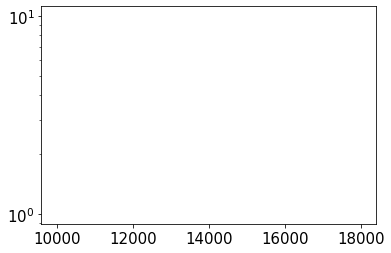

In [13]:
bin_size = (amax-amin)/20
data_hist, data_bins, p = plt.hist(times["data"][mask_analysis["data"]],range=[amin,amax],bins=bins)
plt.yscale('log')
mid_bins = data_bins[:-1] + bin_size/2

/mnt/home/micall12/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


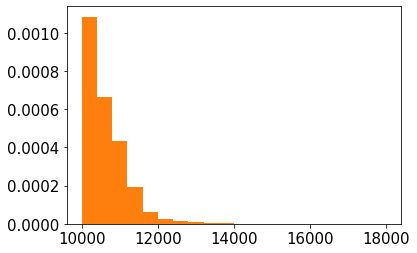

In [14]:
data_hist_norm, data_bins, p = plt.hist(times["data"][mask_analysis["data"]],range=[amin,amax],bins=bins,density=True)
MC_hist_norm, MC_bins, p = plt.hist(times["MC"][mask_analysis["MC"]],weights=weights["MC"][mask_analysis["MC"]],range=[amin,amax],bins=bins,density=True)


/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


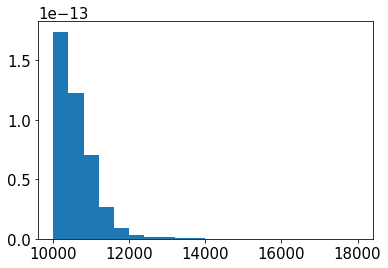

In [153]:
data_MC = data_hist_norm/MC_hist_norm
MC_hist_sq, MC_bins, p = plt.hist(times["MC"][mask_analysis["MC"]],weights=weights["MC"][mask_analysis["MC"]]*weights["MC"][mask_analysis["MC"]],range=[amin,amax],bins=bins)

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0, 0.5, 'Data/MC')

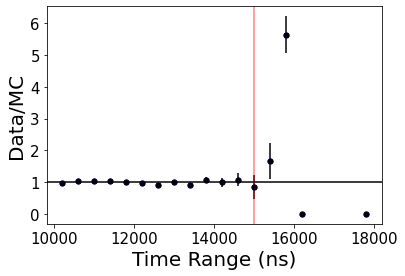

In [156]:
plt.errorbar(mid_bins,data_MC,yerr=np.sqrt(MC_hist_sq),color='b',marker='.',ls='none',markersize=10)
plt.errorbar(mid_bins,data_MC,yerr=1/np.sqrt(data_hist),color='k',marker='.',ls='none',markersize=10)
plt.axhline(y=1,color='k')
plt.axvline(x=15000,color='r',alpha=0.5)
plt.xlabel("Time Range (ns)",fontsize=20)
plt.ylabel("Data/MC",fontsize=20)

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5, 1.0, 'Zoom In Y Axis')

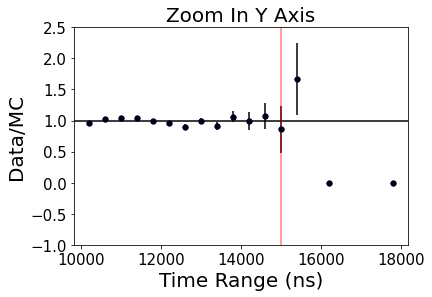

In [157]:
plt.errorbar(mid_bins,data_MC,yerr=np.sqrt(MC_hist_sq),color='b',marker='.',ls='none',markersize=10)
plt.errorbar(mid_bins,data_MC,yerr=1/np.sqrt(data_hist),color='k',ls='none',marker='.',markersize=10)
plt.axhline(y=1,color='k')
plt.axvline(x=15000,color='r',alpha=0.5)
plt.ylim(-1,2.5)
plt.xlabel("Time Range (ns)",fontsize=20)
plt.ylabel("Data/MC",fontsize=20)
plt.title("Zoom In Y Axis",fontsize=20)

Text(0, 0.5, 'Normalized')

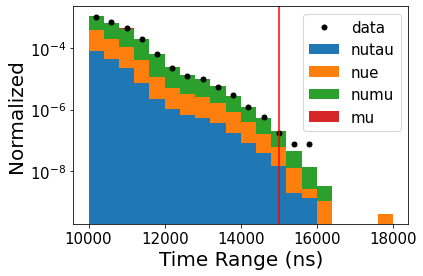

In [82]:
plt.hist(list_times,weights=list_weights,stacked=True,label=MC,range=[amin,amax],bins=bins,density=True)
#plt.errorbar(mid_bins,data_hist_norm,yerr=1/np.sqrt(data_hist_norm),color='k',marker='.',ls='none',markersize=10,label="data")
plt.plot(mid_bins,data_hist_norm,color='k',marker='.',ls='none',markersize=10,label="data")
plt.legend(fontsize=15)
plt.xlabel("Time Range (ns)",fontsize=20)
plt.axvline(x=15000,color='r')
plt.yscale('log')
plt.ylabel("Normalized",fontsize=20)

Text(0, 0.5, 'Normalized')

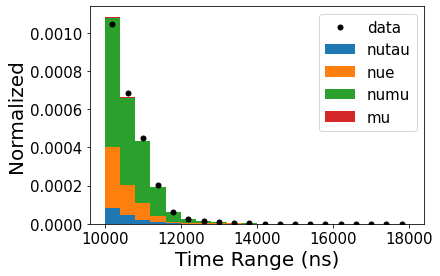

In [86]:
plt.hist(list_times,weights=list_weights,stacked=True,label=MC,range=[amin,amax],bins=bins,density=True)
#plt.errorbar(mid_bins,data_hist_norm,yerr=1/np.sqrt(data_hist_norm),color='k',marker='.',ls='none',markersize=10,label="data")
plt.plot(mid_bins,data_hist_norm,color='k',marker='.',ls='none',markersize=10,label="data")
plt.legend(fontsize=15)
plt.xlabel("Time Range (ns)",fontsize=20)
#plt.yscale('log')
plt.ylabel("Normalized",fontsize=20)

In [90]:
cut_large_times = times['data'][mask_analysis['data']] > 15000
print(sum(cut_large_times))
print(len(cut_large_times),sum(cut_large_times)/len(cut_large_times)*100)

7
97338 0.007191436027039799


## Prob Nu ##

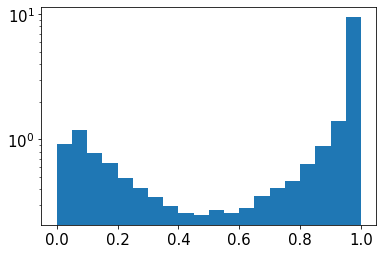

In [172]:
amin=0
amax=1
bins=20
data_hist_probnu, data_bins, p = plt.hist(prob_nu["data"][mask_probnu["data"]],range=[amin,amax],bins=bins,density=True)
plt.yscale('log')
bin_size = (amax-amin)/bins
mid_bins = data_bins[:-1] + bin_size/2

Text(0, 0.5, 'Normalized')

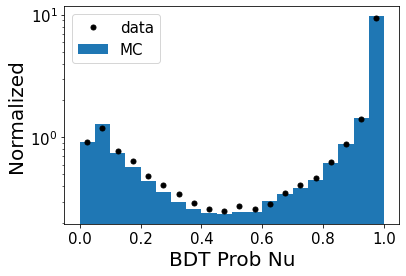

In [173]:
plt.hist(prob_nu['MC'][mask_probnu['MC']],weights=weights['MC'][mask_probnu['MC']],label="MC",range=[amin,amax],bins=bins,density=True)
#plt.errorbar(mid_bins,data_hist_norm,yerr=1/np.sqrt(data_hist_norm),color='k',marker='.',ls='none',markersize=10,label="data")
plt.plot(mid_bins,data_hist_prob,color='k',marker='.',ls='none',markersize=10,label="data")
plt.legend(fontsize=15)
plt.xlabel("BDT Prob Nu",fontsize=20)
plt.yscale('log')
plt.ylabel("Normalized",fontsize=20)

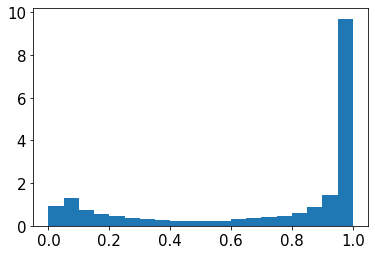

In [174]:
MC_hist_probnu, MC_bins, p = plt.hist(prob_nu["MC"][mask_probnu["MC"]],weights=weights["MC"][mask_probnu["MC"]],range=[amin,amax],bins=bins,density=True)
data_MC_nu = data_hist_probnu/MC_hist_probnu
MC_hist_sq_probnu, MC_bins, p = plt.hist(prob_nu["MC"][mask_probnu["MC"]],weights=weights["MC"][mask_probnu["MC"]]*weights["MC"][mask_probnu["MC"]],range=[amin,amax],bins=bins)

(0.8, 1.2)

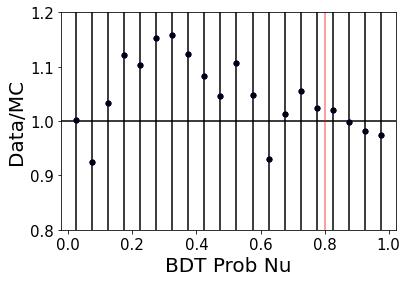

In [175]:
plt.errorbar(mid_bins,data_MC_nu,yerr=np.sqrt(MC_hist_sq_probnu),color='b',marker='.',ls='none',markersize=10)
plt.errorbar(mid_bins,data_MC_nu,yerr=1/np.sqrt(data_hist_probnu),color='k',marker='.',ls='none',markersize=10)
plt.axhline(y=1,color='k')
plt.axvline(x=0.8,color='r',alpha=0.5)
plt.xlabel("BDT Prob Nu",fontsize=20)
plt.ylabel("Data/MC",fontsize=20)
plt.ylim(0.8,1.2)

## CNN Mu ##

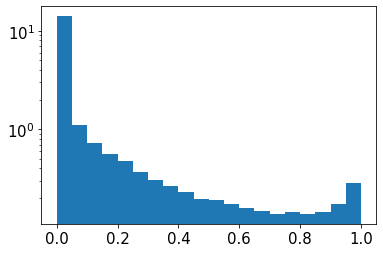

In [176]:
amin=0
amax=1
bins=20
data_hist_cnnmu, data_bins, p = plt.hist(cnn_mu["data"][mask_probnu["data"]],range=[amin,amax],bins=bins,density=True)
plt.yscale('log')
bin_size = (amax-amin)/bins
mid_bins = data_bins[:-1] + bin_size/2

Text(0, 0.5, 'Normalized')

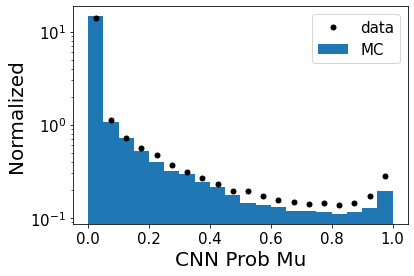

In [177]:
plt.hist(cnn_mu['MC'][mask_probnu['MC']],weights=weights['MC'][mask_probnu['MC']],label="MC",range=[amin,amax],bins=bins,density=True)
#plt.errorbar(mid_bins,data_hist_norm,yerr=1/np.sqrt(data_hist_norm),color='k',marker='.',ls='none',markersize=10,label="data")
plt.plot(mid_bins,data_hist_cnnmu,color='k',marker='.',ls='none',markersize=10,label="data")
plt.legend(fontsize=15)
plt.xlabel("CNN Prob Mu",fontsize=20)
plt.yscale('log')
plt.ylabel("Normalized",fontsize=20)

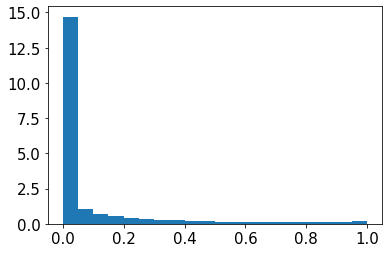

In [178]:
MC_hist_cnnmu, MC_bins, p = plt.hist(cnn_mu["MC"][mask_probnu["MC"]],weights=weights["MC"][mask_probnu["MC"]],range=[amin,amax],bins=bins,density=True)
data_MC_cnnmu = data_hist_cnnmu/MC_hist_cnnmu
MC_hist_sq_cnnmu, MC_bins, p = plt.hist(cnn_mu["MC"][mask_probnu["MC"]],weights=weights["MC"][mask_probnu["MC"]]*weights["MC"][mask_probnu["MC"]],range=[amin,amax],bins=bins)

Text(0, 0.5, 'Data/MC')

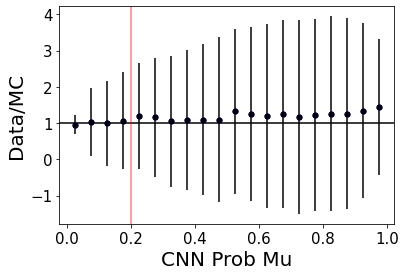

In [189]:
plt.errorbar(mid_bins,data_MC_cnnmu,yerr=np.sqrt(MC_hist_sq_cnnmu),color='b',marker='.',ls='none',markersize=10)
plt.errorbar(mid_bins,data_MC_cnnmu,yerr=1/np.sqrt(data_hist_cnnmu),color='k',marker='.',ls='none',markersize=10)
plt.axhline(y=1,color='k')
plt.axvline(x=0.2,color='r',alpha=0.5)
plt.xlabel("CNN Prob Mu",fontsize=20)
plt.ylabel("Data/MC",fontsize=20)
#plt.ylim(0.8,1.2)

In [180]:
data_hist_cnnmu

array([14.0589927 ,  1.11572036,  0.72468379,  0.55849642,  0.47514825,
        0.37258545,  0.30807014,  0.26824116,  0.23108442,  0.19481842,
        0.19278243,  0.17242257,  0.15702542,  0.14913598,  0.13959229,
        0.14328252,  0.1383198 ,  0.14404601,  0.17331331,  0.28223857])

In [185]:
np.sqrt(14.0589927)

3.7495323308380737